In [32]:

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'mental-health:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F3559763%2F6200306%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20241004%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20241004T110459Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D0e783e0ccaadecfd2b9cf10edcaa4640f509e5d718fd6625828e2514c156a126f793d2c458a9fceae59661dd0df075b36648c15b5a2be3dc10125f2cff6736f27aa343e8ebec1d20cdf1ec6f1174528f1f926d49f892b69a1440d975eda510555f4781fa8f9785d88d8218ec94f9c7a6e2614eec35ec914dbc00e066aa46e255f7127196d2964d15f38e72f9d94c40061baa407e424055243d2ce23bc08f4356f3c4a63d808287f0363a8db9b94222d6ccdab2e48116c02b79836386b905674ed5e72a9ae25ea3b5b33a1534cb81a491c633831ac65081cc43827f1a5cfdea3d59116e0a6a9a92473378176cef605654d7ef990b66ed1f6b9d034e276651fa6d'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 346265 bytes downloaded
Downloaded and uncompressed: mental-health
Data source import complete.


![npr.brightspotcdn.jpg](attachment:f4138c80-758d-4bef-8b7b-f5e4933daf29.jpg)


<p style="text-align:center;"><span style="font-size:48px;"><span style="color:crimson;"><span style="font-family:cursive;"> Hello everyone! </span> </span>  </span></p>

<div style="color:white;
           display:fill;
           border-radius:100px;
           background-color:#5642C5;
           font-size:120%;
           font-family:Verdana;
           letter-spacing:0.5px">

<p style="padding: 50px;
              color:white;">What is mental health?
Mental health includes our emotional, psychological, and social well-being. It affects how we think, feel, and act. It also helps determine how we handle stress, relate to others, and make healthy choices.1 Mental health is important at every stage of life, from childhood and adolescence through adulthood.

</p>
</div>


<div style="color:white;
           display:fill;
           border-radius:100px;
           background-color:#5642C5;
           font-size:120%;
           font-family:Verdana;
           letter-spacing:0.5px">

<p style="padding: 50px;
              color:white;">Why is mental health important for overall health?
    Mental and physical health are equally important components of overall health.  For example, depression increases the risk for many types of physical health problems, particularly long-lasting conditions like diabetes, heart disease, and stroke. Similarly, the presence of chronic conditions can increase the risk for mental illness.

</p>
</div>


<div style="color:white;
           display:fill;
           border-radius:100px;
           background-color:#5642C5;
           font-size:120%;
           font-family:Verdana;
           letter-spacing:0.5px">

<p style="padding: 50px;
              color:white;">In this notebook, I intend to perform analysis among different datasets. First, we will have a comprehensive analysis of the data using the Plotly library. Then, with the regression algorithm, we consider one of the variables as a target and model it. Of course, it is better to use clustering in this data, which I will do in the next notebook.

</p>
</div>


<div style="color:white;
           display:fill;
           border-radius:100px;
           background-color:#5642C5;
           font-size:120%;
           font-family:Verdana;
           letter-spacing:0.5px">

<p style="padding: 30px;
              color:white;">Well, let's get started.
</p>
</div>

# 1- Import Libraries

In [ ]:
#import important libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn import preprocessing
from sklearn import metrics
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)
import warnings
warnings.filterwarnings("ignore")

# 2- Call Datasets

In [33]:
Data1 = pd.read_csv("/kaggle/input/mental-health/1- mental-illnesses-prevalence.csv")
Data2 = pd.read_csv("/kaggle/input/mental-health/4- adult-population-covered-in-primary-data-on-the-prevalence-of-mental-illnesses.csv")
Data3 = pd.read_csv("/kaggle/input/mental-health/6- depressive-symptoms-across-us-population.csv")
Data4 = pd.read_csv("/kaggle/input/mental-health/7- number-of-countries-with-primary-data-on-prevalence-of-mental-illnesses-in-the-global-burden-of-disease-study.csv")

In [34]:
df1 = pd.DataFrame(Data1)
df2 = pd.DataFrame(Data2)
df3 = pd.DataFrame(Data3)
df4 = pd.DataFrame(Data4)

In [37]:
print(df1.head())
print(df2.head())
print(df3.head())
print(df4.head())

        Entity Code  Year  \
0  Afghanistan  AFG  1990   
1  Afghanistan  AFG  1991   
2  Afghanistan  AFG  1992   
3  Afghanistan  AFG  1993   
4  Afghanistan  AFG  1994   

   Schizophrenia disorders (share of population) - Sex: Both - Age: Age-standardized  \
0                                           0.223206                                   
1                                           0.222454                                   
2                                           0.221751                                   
3                                           0.220987                                   
4                                           0.220183                                   

   Depressive disorders (share of population) - Sex: Both - Age: Age-standardized  \
0                                           4.996118                                
1                                           4.989290                                
2                                        

# 3- Functional Describe of All Datasets

In [35]:
def describe(df):


    variables = []
    dtypes = []
    count = []
    unique = []
    missing = []


    for item in df.columns:
        variables.append(item)
        dtypes.append(df[item].dtype)
        count.append(len(df[item]))
        unique.append(len(df[item].unique()))
        missing.append(df[item].isna().sum())


    output = pd.DataFrame({
        'variable': variables,
        'dtype': dtypes,
        'count': count,
        'unique': unique,
        'missing value': missing
    })

    return output

In [36]:
class color:
   BLUE = '\033[94m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

# 4- Output of Describes

In [38]:
print(color.BOLD + color.BLUE + color.UNDERLINE +
      '"The describe table of df1 : Mental illness dataframe"' + color.END)
print(describe(df1))
print("\n")
print(color.BOLD + color.BLUE + color.UNDERLINE +
      '"The describe table of df2 : Adult population, mental illnesses"' + color.END)
print(describe(df2))
print("\n")
print(color.BOLD + color.BLUE + color.UNDERLINE +
      '"The describe table of df3 : Depressive"' + color.END)
print(describe(df3))
print("\n")
print(color.BOLD + color.BLUE + color.UNDERLINE +
      '"The describe table of df4 : Number of countries"' + color.END)
print(describe(df4))

"The describe table of df1 : Mental illness dataframe"
                                            variable    dtype  count  unique  \
0                                             Entity   object   6420     214   
1                                               Code   object   6420     206   
2                                               Year    int64   6420      30   
3  Schizophrenia disorders (share of population) ...  float64   6420    6406   
4  Depressive disorders (share of population) - S...  float64   6420    6416   
5  Anxiety disorders (share of population) - Sex:...  float64   6420    6417   
6  Bipolar disorders (share of population) - Sex:...  float64   6420    6385   
7  Eating disorders (share of population) - Sex: ...  float64   6420    6417   

   missing value  
0              0  
1            270  
2              0  
3              0  
4              0  
5              0  
6              0  
7              0  


"The describe table of df2 : Adult population, ment

# 5- Some Visualizations with Plotly

In [45]:
# Sorting the DataFrame
df2.sort_values(by="Major depression", inplace=True)

# Creating a horizontal bar plot using Plotly Express
import plotly.express as px

fig = px.bar(df2,
             x="Major depression",
             y="Entity",
             orientation='h',
             color='Bipolar disorder')

# Displaying the plot
fig.show()


In [40]:
df2.sort_values(by= "Eating disorders" ,inplace=True)
plt.figure(dpi=200)
fig = px.bar(df2, x="Eating disorders", y="Entity", orientation='h',color='Dysthymia')
fig.show()

<Figure size 1280x960 with 0 Axes>

In [41]:
df2.replace(to_replace="<0.1", value=0.1, regex=True, inplace=True)

In [46]:
df2['Schizophrenia'] = df2['Schizophrenia'].astype(float)

In [47]:
df2.sort_values(by= "Schizophrenia" ,inplace=True)
plt.figure(dpi=200)
fig = px.bar(df2, x="Schizophrenia", y="Entity", orientation='h',color='Anxiety disorders')
fig.show()

<Figure size 1280x960 with 0 Axes>

# 6- Amazing Dynamik Subplot with Plotly and go

In [48]:
fig = make_subplots(rows=1, cols=2, specs=[[{}, {}]], shared_xaxes=True,
                    shared_yaxes=False, vertical_spacing=0.001)

x1 = ["Andean Latin America", "West Sub-Saharan Africa", "Tropical Latin America", "Central Asia", "Central Europe",
    "Central Sub-Saharan Africa", "Southern Latin America", "North Africa/Middle East", "Southern Sub-Saharan Africa",
    "Southeast Asia", "Oceania", "Central Latin America", "Eastern Europe", "South Asia", "East Sub-Saharan Africa",
    "Western Europe", "World", "East Asia", "Caribbean", "Asia Pacific", "Australasia", "North America"]

fig.append_trace(go.Bar(
    x=df2["Bipolar disorder"],
    y=x1,
    marker=dict(
        color='rgba(50, 171, 96, 0.6)',
        line=dict(
            color='rgba(20, 10, 56, 1.0)',
            width=0),
    ),
    name='Bipolar disorder in Mental Health',
    orientation='h',
), 1, 1)

fig.append_trace(go.Scatter(
    x=df2["Major depression"], y=x1,
    mode='lines+markers',
    line_color='rgb(40, 0, 128)',
    name='Major depression in Mental Health',
), 1, 2)

fig.update_layout(
    title='Major depression and Bipolar disorder',
    yaxis=dict(
        showgrid=False,
        showline=False,
        showticklabels=True,
        domain=[0, 0.85],
    ),
    yaxis2=dict(
        showgrid=False,
        showline=True,
        showticklabels=False,
        linecolor='rgba(102, 102, 102, 0.8)',
        linewidth=5,
        domain=[0, 0.85],
    ),
    xaxis=dict(
        zeroline=False,
        showline=False,
        showticklabels=True,
        showgrid=True,
        domain=[0, 0.45],
    ),
    xaxis2=dict(
        zeroline=False,
        showline=False,
        showticklabels=True,
        showgrid=True,
        domain=[0.47, 1],
        side='top',
        dtick=10000,
    ),
    legend=dict(x=0.029, y=1.038, font_size=10),
    margin=dict(l=100, r=20, t=70, b=70),
    paper_bgcolor='rgb(248, 248, 255)',
    plot_bgcolor='rgb(248, 248, 255)',
)

annotations = []


# Adding labels
for ydn, yd, xd in zip(df2["Major depression"], df2["Bipolar disorder"], x1):
    # labeling the scatter savings
    annotations.append(dict(xref='x2', yref='y2',
                            y=xd, x=ydn+10,
                            text='{:,}'.format(ydn) + '%',
                            font=dict(family='Arial', size=10,
                                      color='rgb(128, 0, 128)'),
                            showarrow=False))
    # labeling the bar net worth
    annotations.append(dict(xref='x1', yref='y1',
                            y=xd, x=yd+10 ,
                            text=str(yd) + '%',
                            font=dict(family='Arial', size=10,
                                      color='rgb(50, 171, 96)'),
                            showarrow=False))
# Source
annotations.append(dict(xref='paper', yref='paper',
                        x=-0.2, y=-0.109,
                        text="Mental health visualization",
                        font=dict(family='Arial', size=20, color='rgb(150,150,150)'),
                        showarrow=False))

fig.update_layout(annotations=annotations)

fig.show()

# 7- Multiple Analysis

In [49]:
x = ["Appetite change", "Average across symptoms", "Depressed mood", "Difficulty concentrating", "Loss of interest",
    "Low energy", "Low self-esteem", "Psychomotor agitation", "Psychomotor agitation", "Sleep problems", "Suicidal ideation"]

fig = go.Figure()
# Create and style traces
fig.add_trace(go.Scatter(x=x, y=df3["Nearly every day"], name='Nearly every day',
                         line=dict(color='firebrick', width=4)))
fig.add_trace(go.Scatter(x=x, y=df3["More than half the days"], name = 'More than half the days',
                         line=dict(color='royalblue', width=4)))
fig.add_trace(go.Scatter(x=x, y=df3["Several days"], name='Several days',
                         line=dict(color='black', width=4,
                              dash='dashdot') # dash options include 'dash', 'dot', and 'dashdot'
))

# Edit the layout
fig.update_layout(title='Depressive symptoms across us population',
                   xaxis_title='Entity',
                   yaxis_title='Types of days')


fig.show()

In [50]:
x = ["Alcohol use disorders", "Amphetamine use disorders", "Anorexia nervosa", "Anxiety disorders",
     "Attention-deficit hyperactivity disorder", "Autism spectrum disorders", "Bipolar disorder",
     "Bulimia nervosa", "Cannabis use disorders", "Cocaine use disorders", "Dysthymia","Major depressive disorder",
    "Opioid use disorders", "Other drug use disorders", "Personality disorders"]

fig = go.Figure()
# Create and style traces
fig.add_trace(go.Scatter(x=x, y=df4["Number of countries with primary data on prevalence of mental disorders"],
                         name='Nearly every day',
                         line=dict(color='firebrick', width=4)))


# Edit the layout
fig.update_layout(title='mental illnesses in the global burden of disease study',
                   xaxis_title='illnesses',
                   yaxis_title='Number of countries')


fig.show()

# 8- Rename Columns

In [51]:
df1_column_names = list(df1.columns.values)
df1_column_names

['Entity',
 'Code',
 'Year',
 'Schizophrenia disorders (share of population) - Sex: Both - Age: Age-standardized',
 'Depressive disorders (share of population) - Sex: Both - Age: Age-standardized',
 'Anxiety disorders (share of population) - Sex: Both - Age: Age-standardized',
 'Bipolar disorders (share of population) - Sex: Both - Age: Age-standardized',
 'Eating disorders (share of population) - Sex: Both - Age: Age-standardized']

In [52]:
df1 = df1.rename(columns={'Schizophrenia disorders (share of population) - Sex: Both - Age: Age-standardized': 'Schizophrenia disorders',
                          'Depressive disorders (share of population) - Sex: Both - Age: Age-standardized': 'Depressive disorders',
                         'Anxiety disorders (share of population) - Sex: Both - Age: Age-standardized':'Anxiety disorders',
                         'Bipolar disorders (share of population) - Sex: Both - Age: Age-standardized':'Bipolar disorders',
                         'Eating disorders (share of population) - Sex: Both - Age: Age-standardized':'Eating disorders'})

In [53]:
df1

,Entity,Code,Year,Schizophrenia disorders,Depressive disorders,Anxiety disorders,Bipolar disorders,Eating disorders
0,Afghanistan,AFG,1990,0.223206,4.996118,4.713314,0.703023,0.127700
1,Afghanistan,AFG,1991,0.222454,4.989290,4.702100,0.702069,0.123256
2,Afghanistan,AFG,1992,0.221751,4.981346,4.683743,0.700792,0.118844
3,Afghanistan,AFG,1993,0.220987,4.976958,4.673549,0.700087,0.115089
4,Afghanistan,AFG,1994,0.220183,4.977782,4.670810,0.699898,0.111815
...,...,...,...,...,...,...,...,...
6415,Zimbabwe,ZWE,2015,0.201042,3.407624,3.184012,0.538596,0.095652
6416,Zimbabwe,ZWE,2016,0.201319,3.410755,3.187148,0.538593,0.096662
6417,Zimbabwe,ZWE,2017,0.201639,3.411965,3.188418,0.538589,0.097330
6418,Zimbabwe,ZWE,2018,0.201976,3.406929,3.172111,0.538585,0.097909


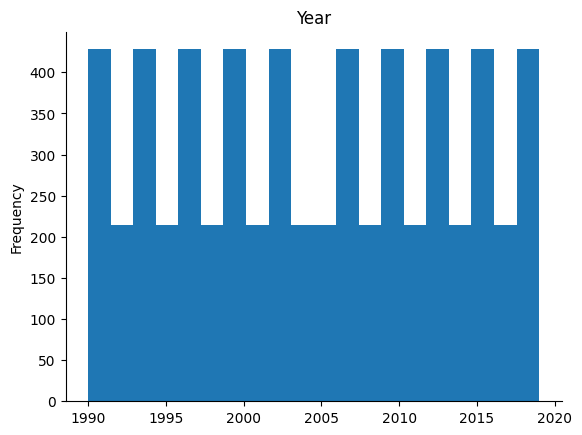

In [55]:
# @title Year

from matplotlib import pyplot as plt
df1['Year'].plot(kind='hist', bins=20, title='Year')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [54]:
df1_variables = df1[["Schizophrenia disorders","Depressive disorders","Anxiety disorders","Bipolar disorders",
                       "Eating disorders"]]

In [56]:
df1_variables

,Schizophrenia disorders,Depressive disorders,Anxiety disorders,Bipolar disorders,Eating disorders
0,0.223206,4.996118,4.713314,0.703023,0.127700
1,0.222454,4.989290,4.702100,0.702069,0.123256
2,0.221751,4.981346,4.683743,0.700792,0.118844
3,0.220987,4.976958,4.673549,0.700087,0.115089
4,0.220183,4.977782,4.670810,0.699898,0.111815
...,...,...,...,...,...
6415,0.201042,3.407624,3.184012,0.538596,0.095652
6416,0.201319,3.410755,3.187148,0.538593,0.096662
6417,0.201639,3.411965,3.188418,0.538589,0.097330
6418,0.201976,3.406929,3.172111,0.538585,0.097909


# 9- Correlation

In [57]:
Corrmat = df1_variables.corr()

<Axes: >

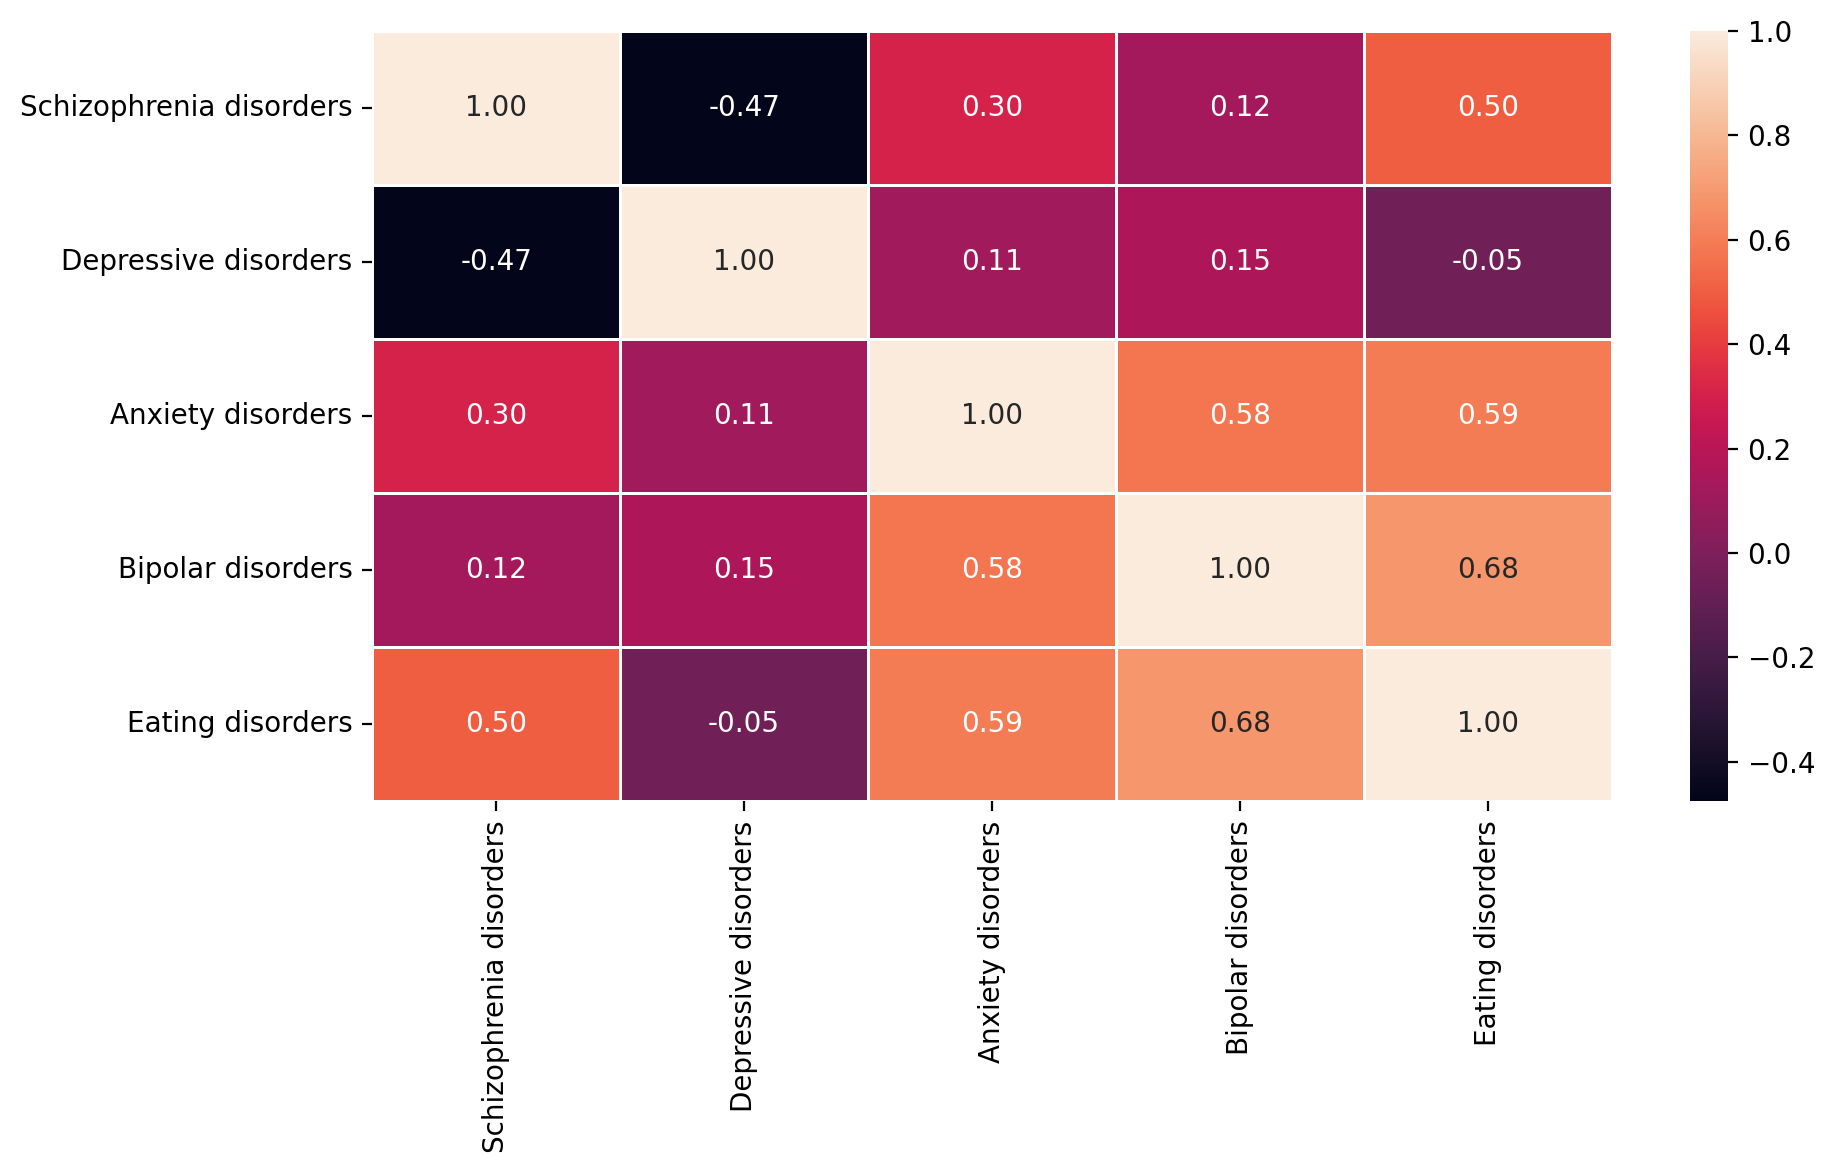

In [58]:
plt.figure(figsize=(10, 5), dpi=200)
sns.heatmap(Corrmat, annot=True,fmt=".2f", linewidth=.5)

# 10- Scatter and Box plot

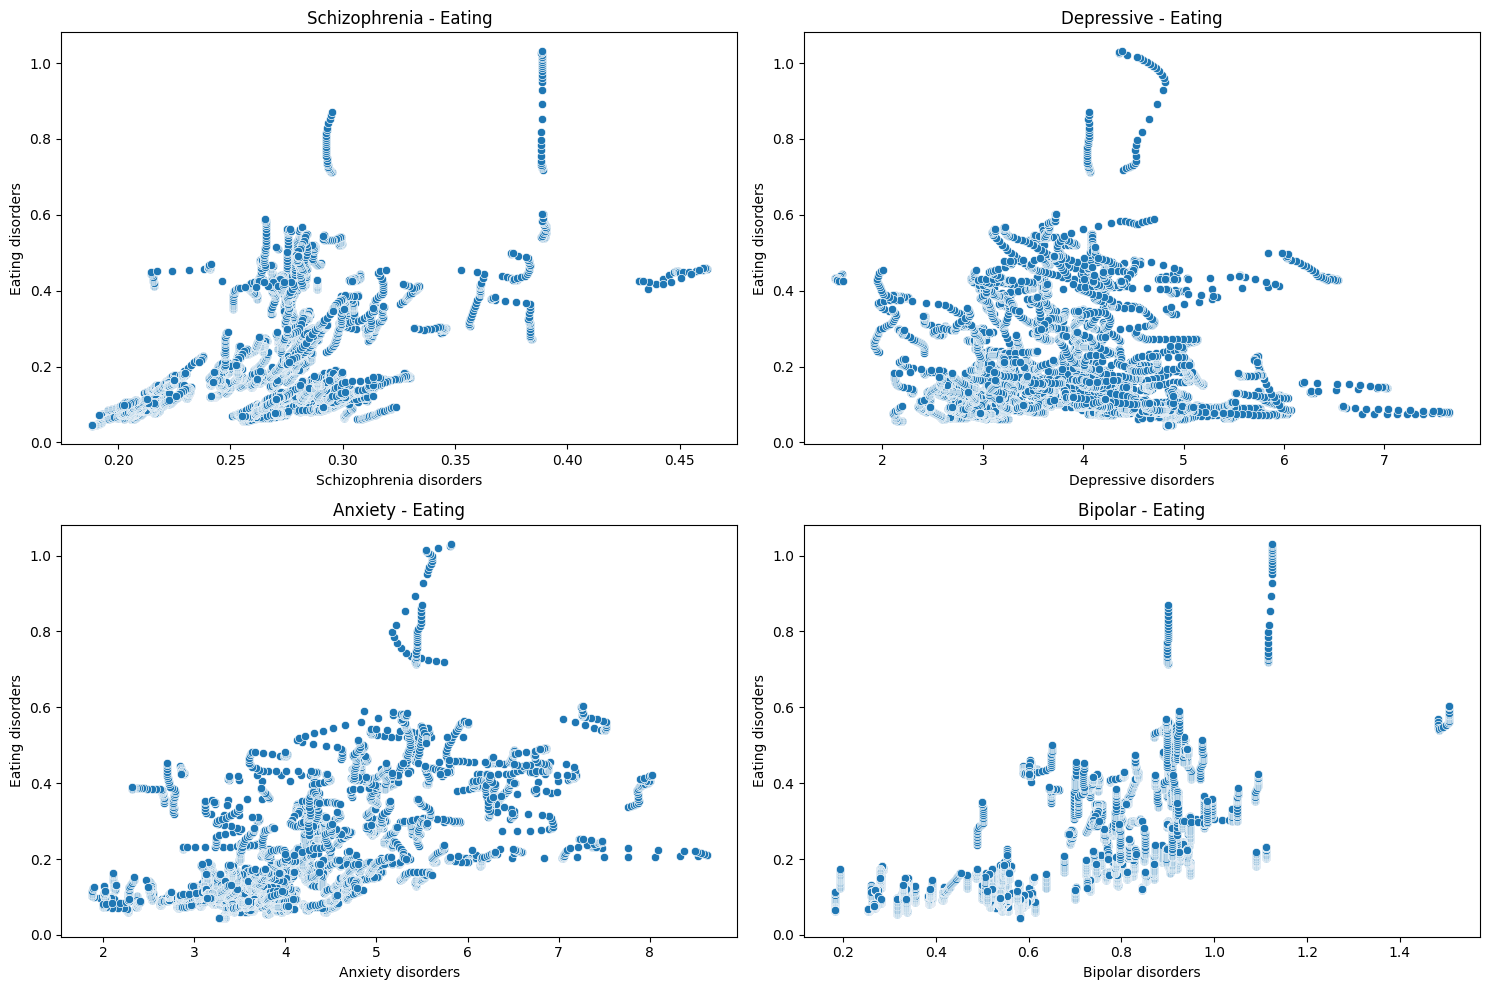

In [59]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(ncols=2,nrows=2,figsize= (15,10))

ax1.set_title('Schizophrenia - Eating')
sns.scatterplot(x="Schizophrenia disorders", y="Eating disorders", data=df1_variables, ax=ax1)

ax2.set_title('Depressive - Eating')
sns.scatterplot(x='Depressive disorders', y="Eating disorders", data=df1_variables, ax=ax2)

ax3.set_title('Anxiety - Eating')
sns.scatterplot(x='Anxiety disorders', y="Eating disorders", data=df1_variables, ax=ax3)

ax4.set_title('Bipolar - Eating')
sns.scatterplot(x='Bipolar disorders', y="Eating disorders", data=df1_variables, ax=ax4)

plt.tight_layout()

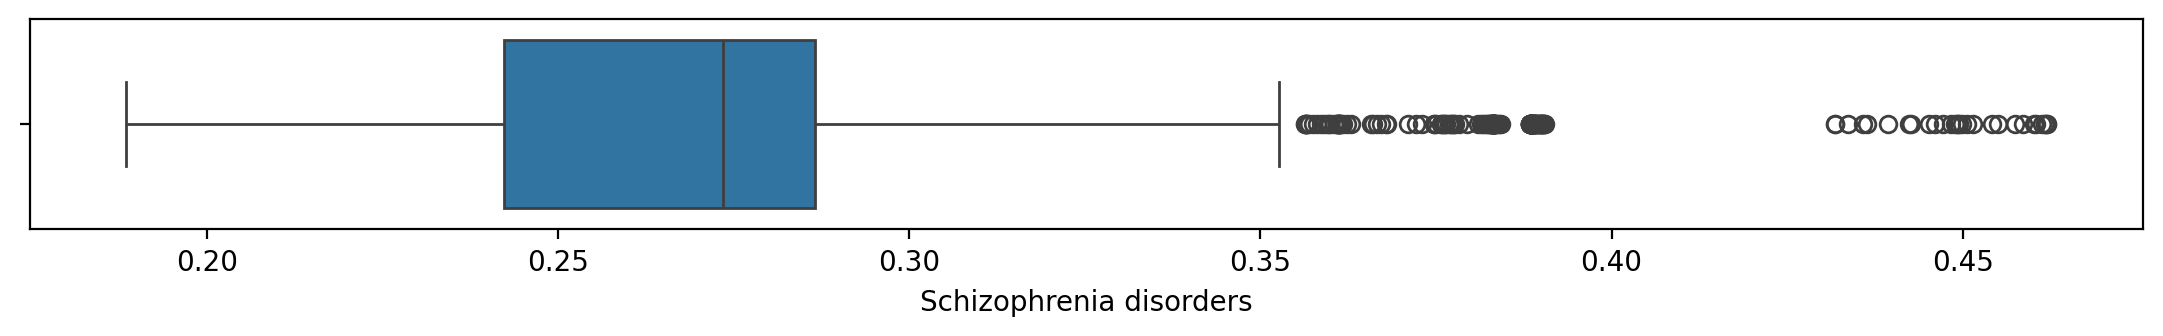

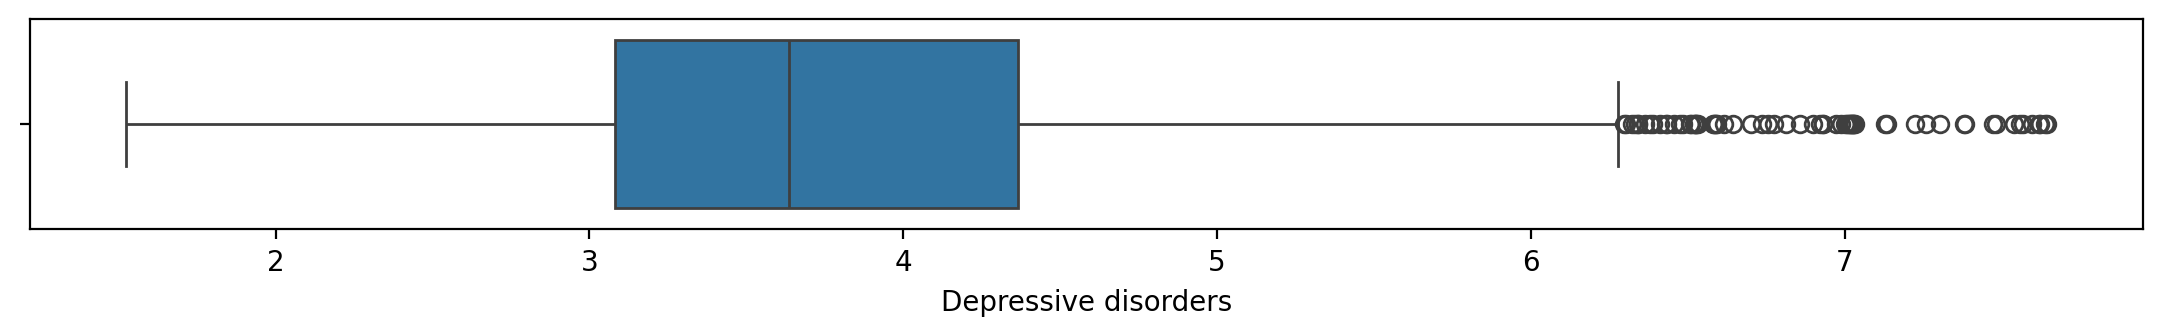

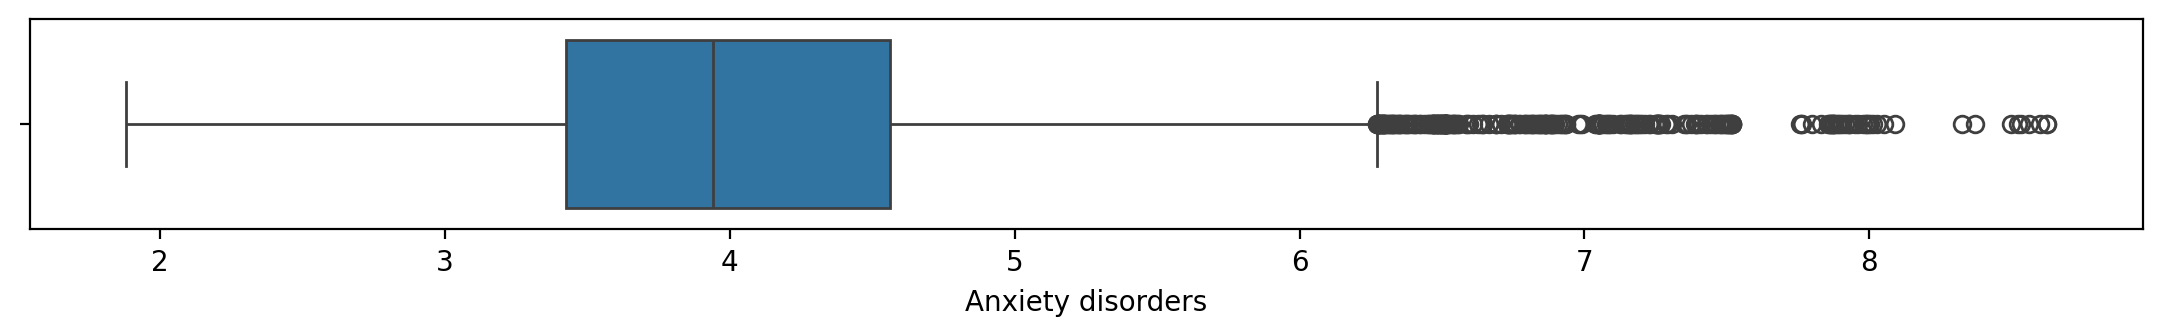

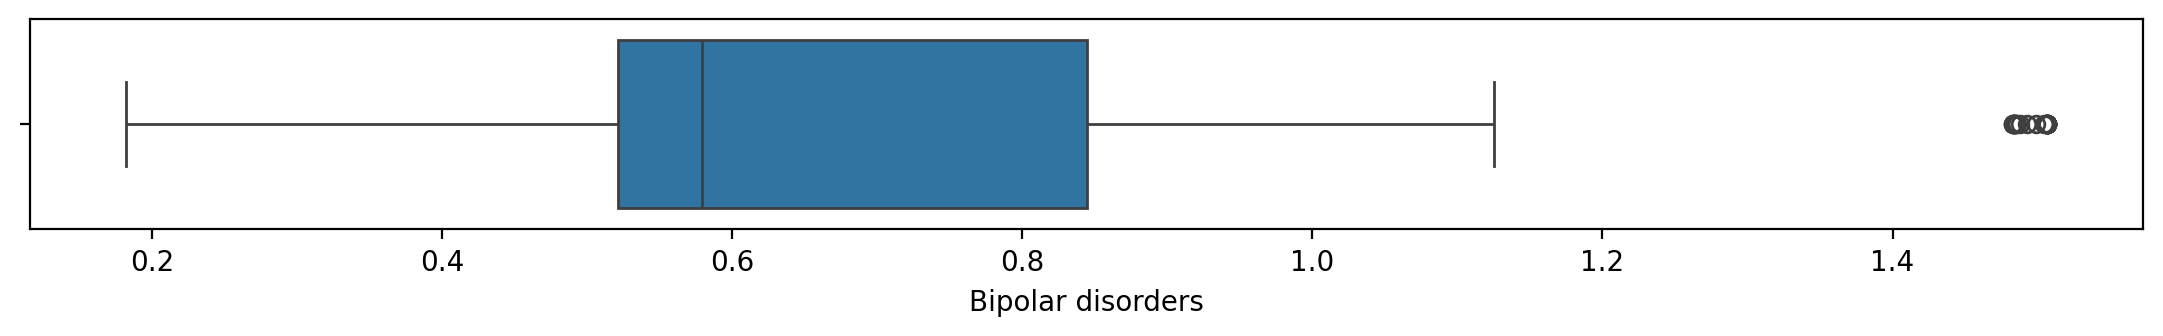

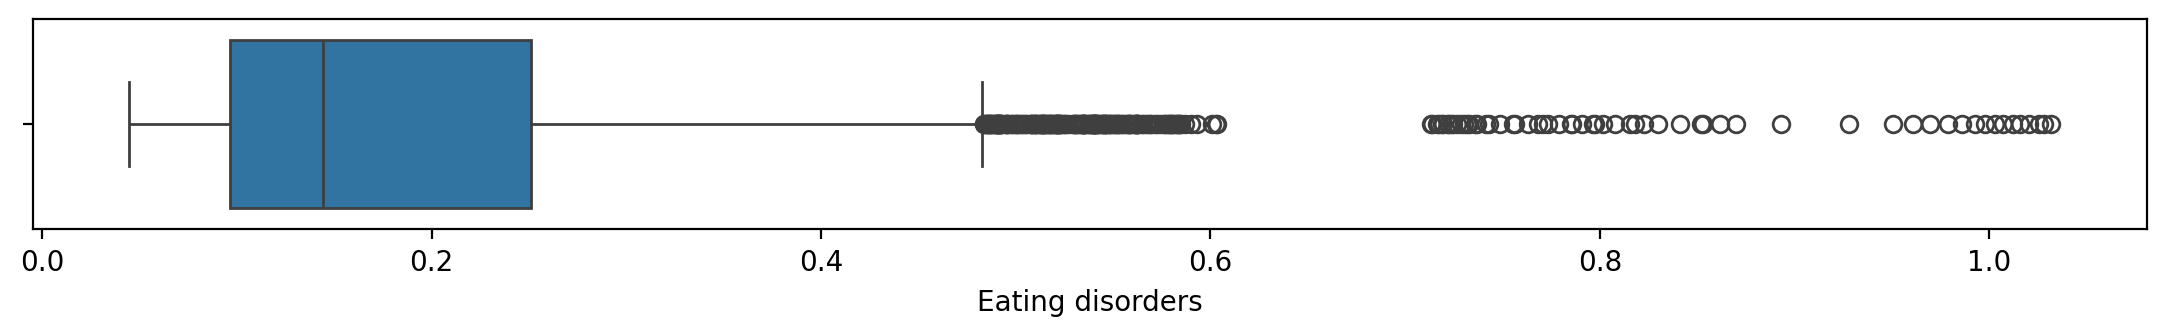

In [60]:
Numerical = ['Schizophrenia disorders', 'Depressive disorders','Anxiety disorders','Bipolar disorders','Eating disorders']
i = 0
while i < 5:
    fig = plt.figure(figsize = [30,3], dpi=200)
    plt.subplot(2,2,1)
    sns.boxplot(x = Numerical[i], data = df1_variables)
    i += 1
    plt.show()

Creat model

# 11- Normalize

In [61]:
features = ['Schizophrenia disorders', 'Depressive disorders','Anxiety disorders','Bipolar disorders']
X_model = df1[features]
y_model = df1["Eating disorders"]

In [62]:
scaler = preprocessing.MinMaxScaler()
X_model_norm = scaler.fit_transform(X_model)

In [63]:
X_model_norm

array([[0.12714204, 0.56728135, 0.42008448, 0.39345779],
       [0.12439376, 0.56616628, 0.41842183, 0.39273757],
       [0.1218262 , 0.56486898, 0.41570011, 0.39177399],
       ...,
       [0.04832425, 0.30858363, 0.19399437, 0.26936249],
       [0.0495569 , 0.30776117, 0.19157658, 0.26935944],
       [0.05140367, 0.30589079, 0.1863733 , 0.26935592]])

# 12- Simple Linear Regression

In [64]:
X_train, X_test, y_train, y_test = train_test_split(X_model_norm, y_model, test_size=20, random_state=42)

In [65]:
print("Shape of x_train : ", X_train.shape)
print("Shape of y_train : ", y_train.shape)
print("Shape of x_test : ", X_test.shape)
print("Shape of y_test : ", y_test.shape)

Shape of x_train :  (6400, 4)
Shape of y_train :  (6400,)
Shape of x_test :  (20, 4)
Shape of y_test :  (20,)


In [66]:
Model = LinearRegression()
Model.fit(X_train, y_train)

LinearRegression()

In [67]:
y_pred = Model.predict(X_test)

In [68]:
print("Mean Absolute Error of Model is: ", metrics.mean_absolute_error(y_test,y_pred))
print("Mean Squared Error of Model is: ", metrics.mean_squared_error(y_test,y_pred))
print("Root Mean Squared of Model is: ", np.sqrt(metrics.mean_squared_error(y_test,y_pred)))
print("R2 Score of Model is: ", metrics.r2_score(y_test,y_pred))

Mean Absolute Error of Model is:  0.08003250281357932
Mean Squared Error of Model is:  0.02178632883846133
Root Mean Squared of Model is:  0.14760192694697902
R2 Score of Model is:  0.6289967829652676


In [69]:
k_fold = KFold(10)
print (cross_val_score(Model, X_model_norm, y_model.ravel(), cv=k_fold, n_jobs=1))

[0.67019159 0.30224538 0.34774549 0.6311535  0.62898747 0.59061848
 0.66269011 0.57389516 0.64517085 0.84017723]


# 13- Higher Dimension Linear Regression

In [70]:
def check(Dimension, testsize):
    r2 = 0.6289
    for column in X_model:
        New_Col_name = column + str(Dimension)
        New_Col_value = X_model[column]**Dimension
        X_model.insert(0, New_Col_name, New_Col_value)
        X_train, X_test, y_train, y_test = train_test_split(X_model, y_model,test_size=testsize,random_state=0)
        New_model = LinearRegression()
        New_model.fit(X_train, y_train)
        y_pred = New_model.predict (X_test)
        r2_new = metrics.r2_score(y_test, y_pred)
        if r2_new < r2:
            X_model.drop([New_Col_name], axis=1, inplace=True)
        else:
            r2 = r2_new

    print("R2 score is: ", r2)
check(2,0.2)

R2 score is:  0.6554298773488345


In [71]:
X_model

,Bipolar disorders2,Anxiety disorders2,Depressive disorders2,Schizophrenia disorders2,Schizophrenia disorders,Depressive disorders,Anxiety disorders,Bipolar disorders
0,0.494242,22.215329,24.961195,0.049821,0.223206,4.996118,4.713314,0.703023
1,0.492901,22.109744,24.893013,0.049486,0.222454,4.989290,4.702100,0.702069
2,0.491109,21.937448,24.813805,0.049174,0.221751,4.981346,4.683743,0.700792
3,0.490122,21.842057,24.770114,0.048835,0.220987,4.976958,4.673549,0.700087
4,0.489857,21.816466,24.778314,0.048481,0.220183,4.977782,4.670810,0.699898
...,...,...,...,...,...,...,...,...
6415,0.290085,10.137934,11.611901,0.040418,0.201042,3.407624,3.184012,0.538596
6416,0.290082,10.157910,11.633250,0.040529,0.201319,3.410755,3.187148,0.538593
6417,0.290078,10.166010,11.641508,0.040658,0.201639,3.411965,3.188418,0.538589
6418,0.290074,10.062288,11.607165,0.040794,0.201976,3.406929,3.172111,0.538585


# 14- Dot Model

In [72]:
Bipolar_Anx = X_model["Bipolar disorders"]*X_model["Anxiety disorders"]
Bipolar_Anx2 = X_model["Bipolar disorders2"]*X_model["Anxiety disorders2"]
Dep_Schi = X_model["Depressive disorders"]* X_model["Schizophrenia disorders"]
Dep_Schi2 = X_model["Depressive disorders2"]* X_model["Schizophrenia disorders2"]

In [73]:
X_model.insert(0, "Bipolar_Anx", Bipolar_Anx)
X_model.insert(0, "Bipolar_Anx2", Bipolar_Anx2)
X_model.insert(0, "Dep_Schi", Dep_Schi)
X_model.insert(0, "Dep_Schi2", Dep_Schi2)

In [74]:
X_train, X_test, y_train, y_test = train_test_split(X_model, y_model,test_size=0.2,random_state=0)
Model = LinearRegression()
Model.fit(X_train, y_train)
y_pred = Model.predict(X_test)
r2 = metrics.r2_score(y_test, y_pred)
r2

0.6779169482589387

# 15- Display Model's Output

In [75]:
a = X_test["Bipolar disorders"]
b = y_test
c = X_test["Bipolar disorders"]
d = y_pred

In [76]:
font1 = {'family':'fantasy','color':'blue','size':20}
font2 = {'family':'serif','color':'darkred','size':20}
font3 = {'family':'cursive','color':'green','size':20}

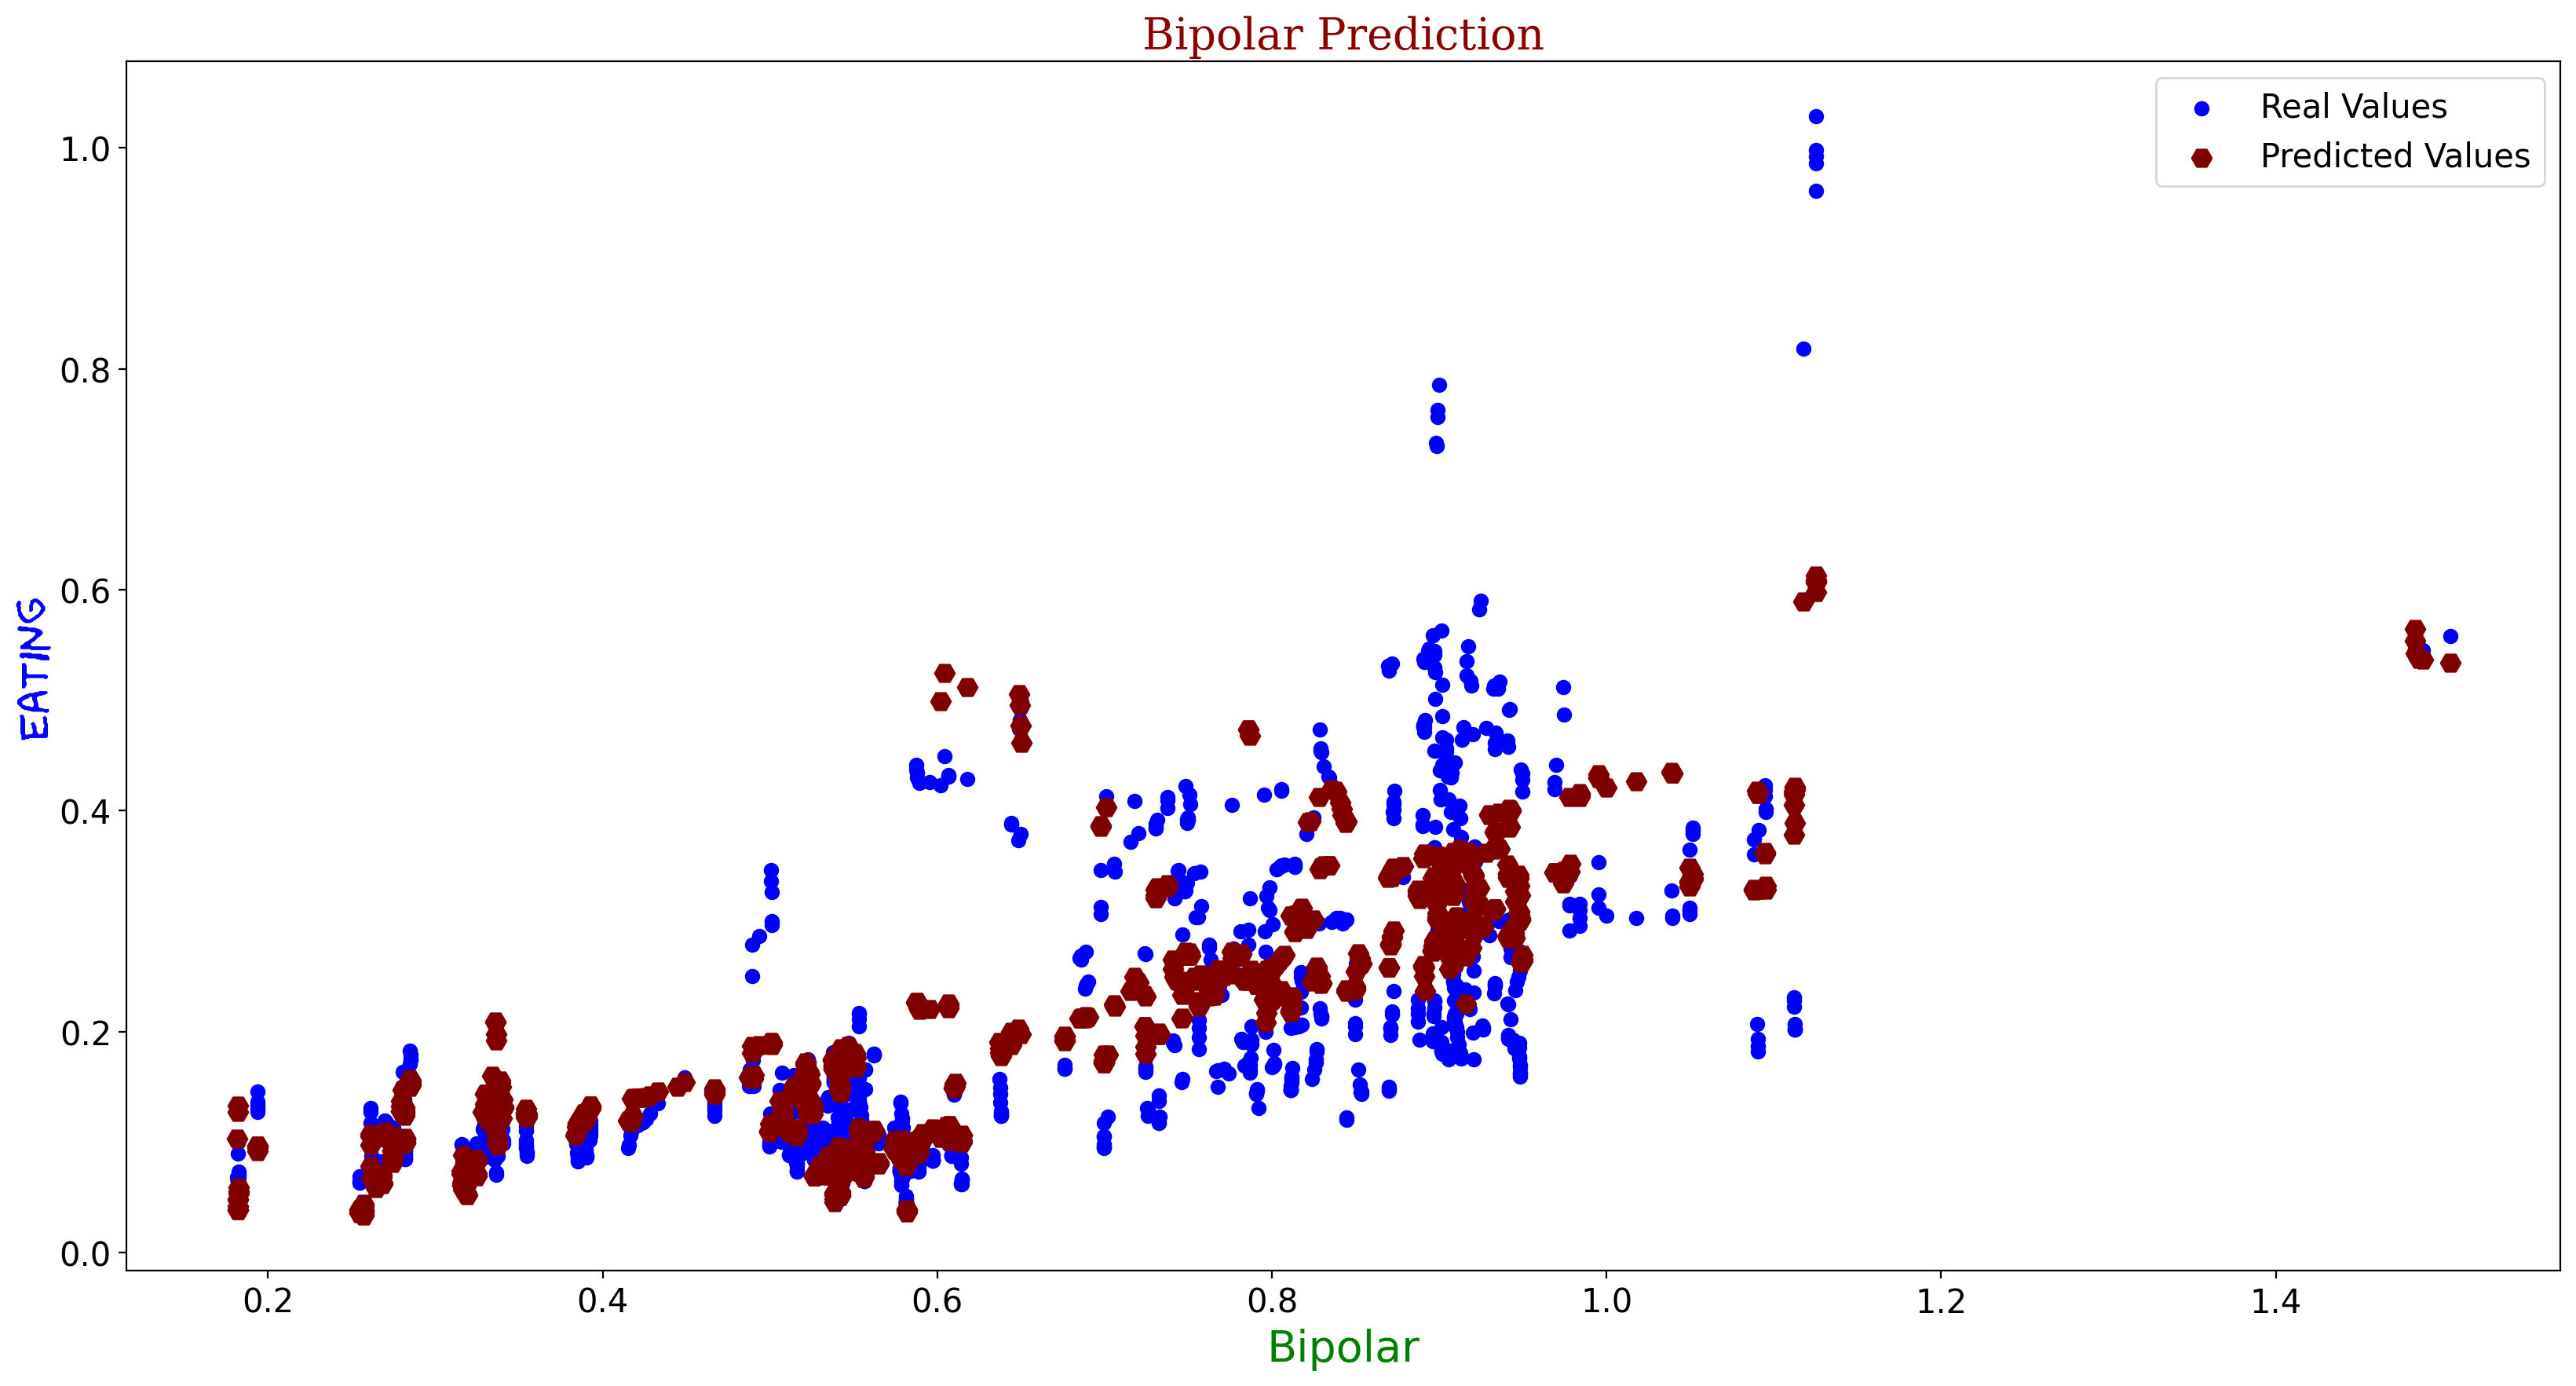

In [77]:
plt.figure(figsize= (20,10), dpi=200)
plt.title("Bipolar Prediction",fontdict=font2)
plt.xlabel("Bipolar",fontdict= font3)
plt.ylabel("Eating",fontdict=font1)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.scatter(a,b, color = 'blue', label = "Real Values")
plt.scatter(c,d, color = 'maroon', label = "Predicted Values", marker="H", s=80)
plt.legend(fontsize=15)
plt.show()

In [78]:
a1 = X_test["Schizophrenia disorders"]
b1 = y_test
c1 = X_test["Schizophrenia disorders"]
d1 = y_pred

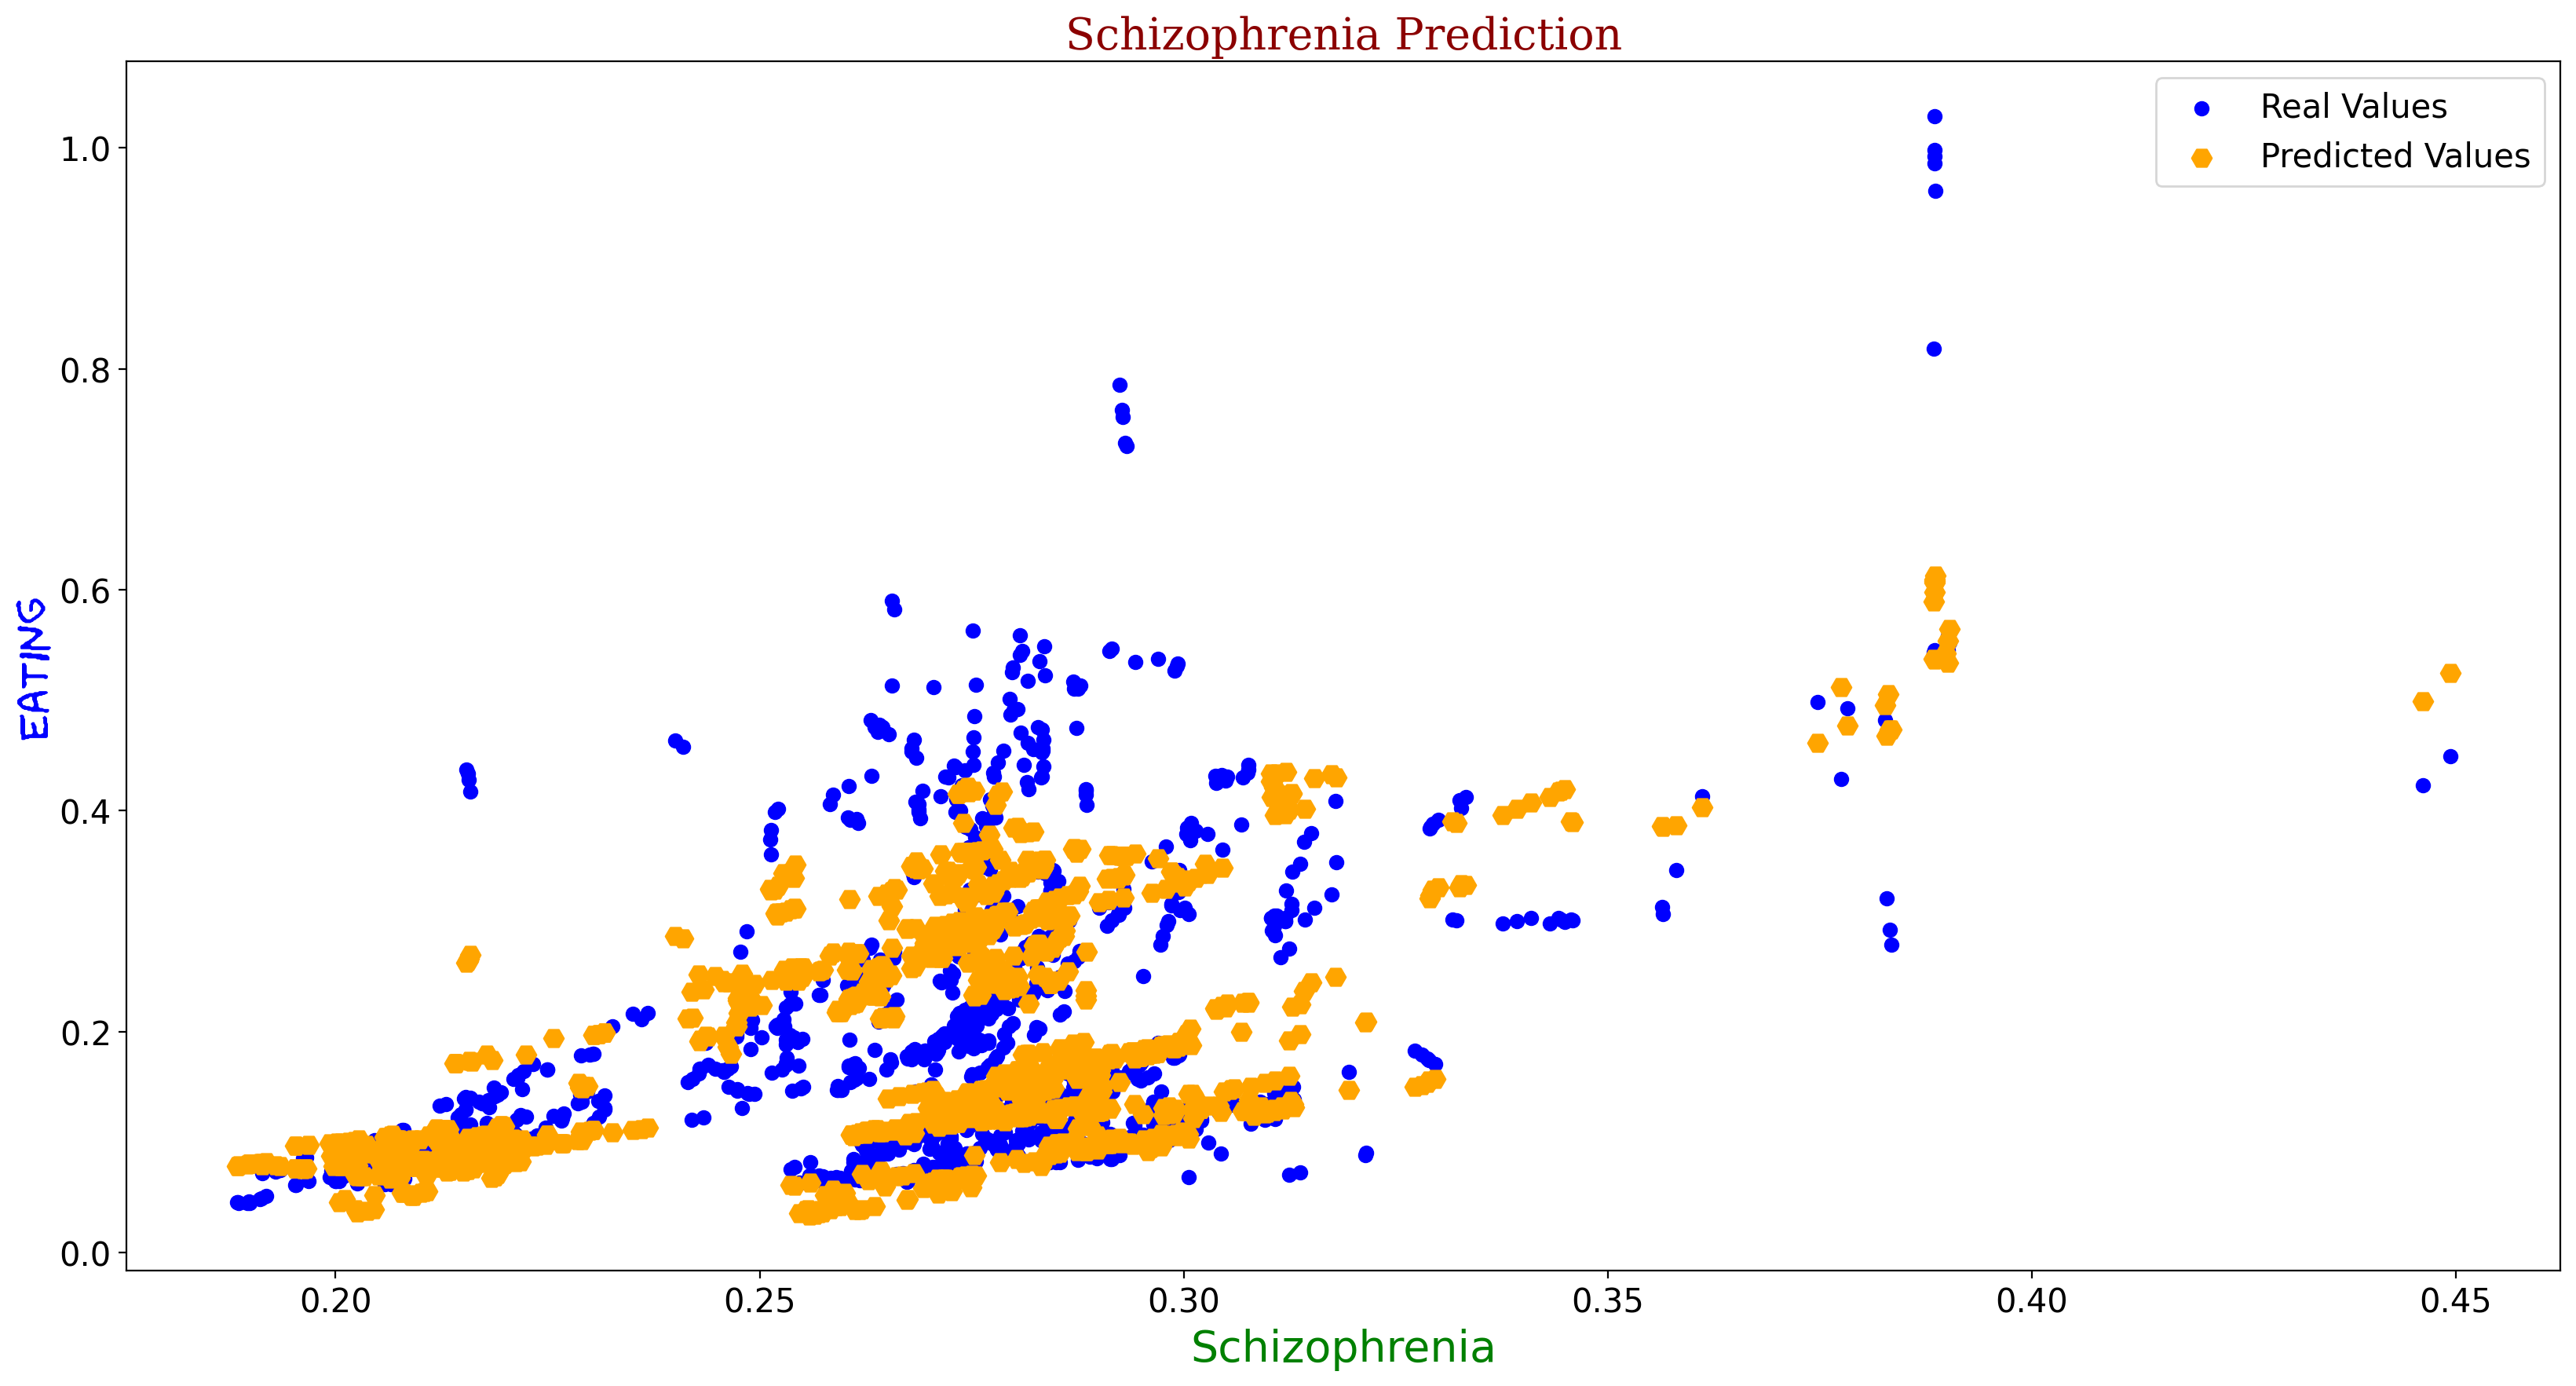

In [79]:
plt.figure(figsize= (20,10), dpi=200)
plt.title("Schizophrenia Prediction",fontdict=font2)
plt.xlabel("Schizophrenia",fontdict= font3)
plt.ylabel("Eating",fontdict=font1)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.scatter(a1,b1, color = 'blue', label = "Real Values")
plt.scatter(c1,d1, color = 'Orange', label = "Predicted Values", marker="H", s=80)
plt.legend(fontsize=15)
plt.show()

In [80]:
a2 = X_test["Anxiety disorders"]
b2 = y_test
c2 = X_test["Anxiety disorders"]
d2 = y_pred

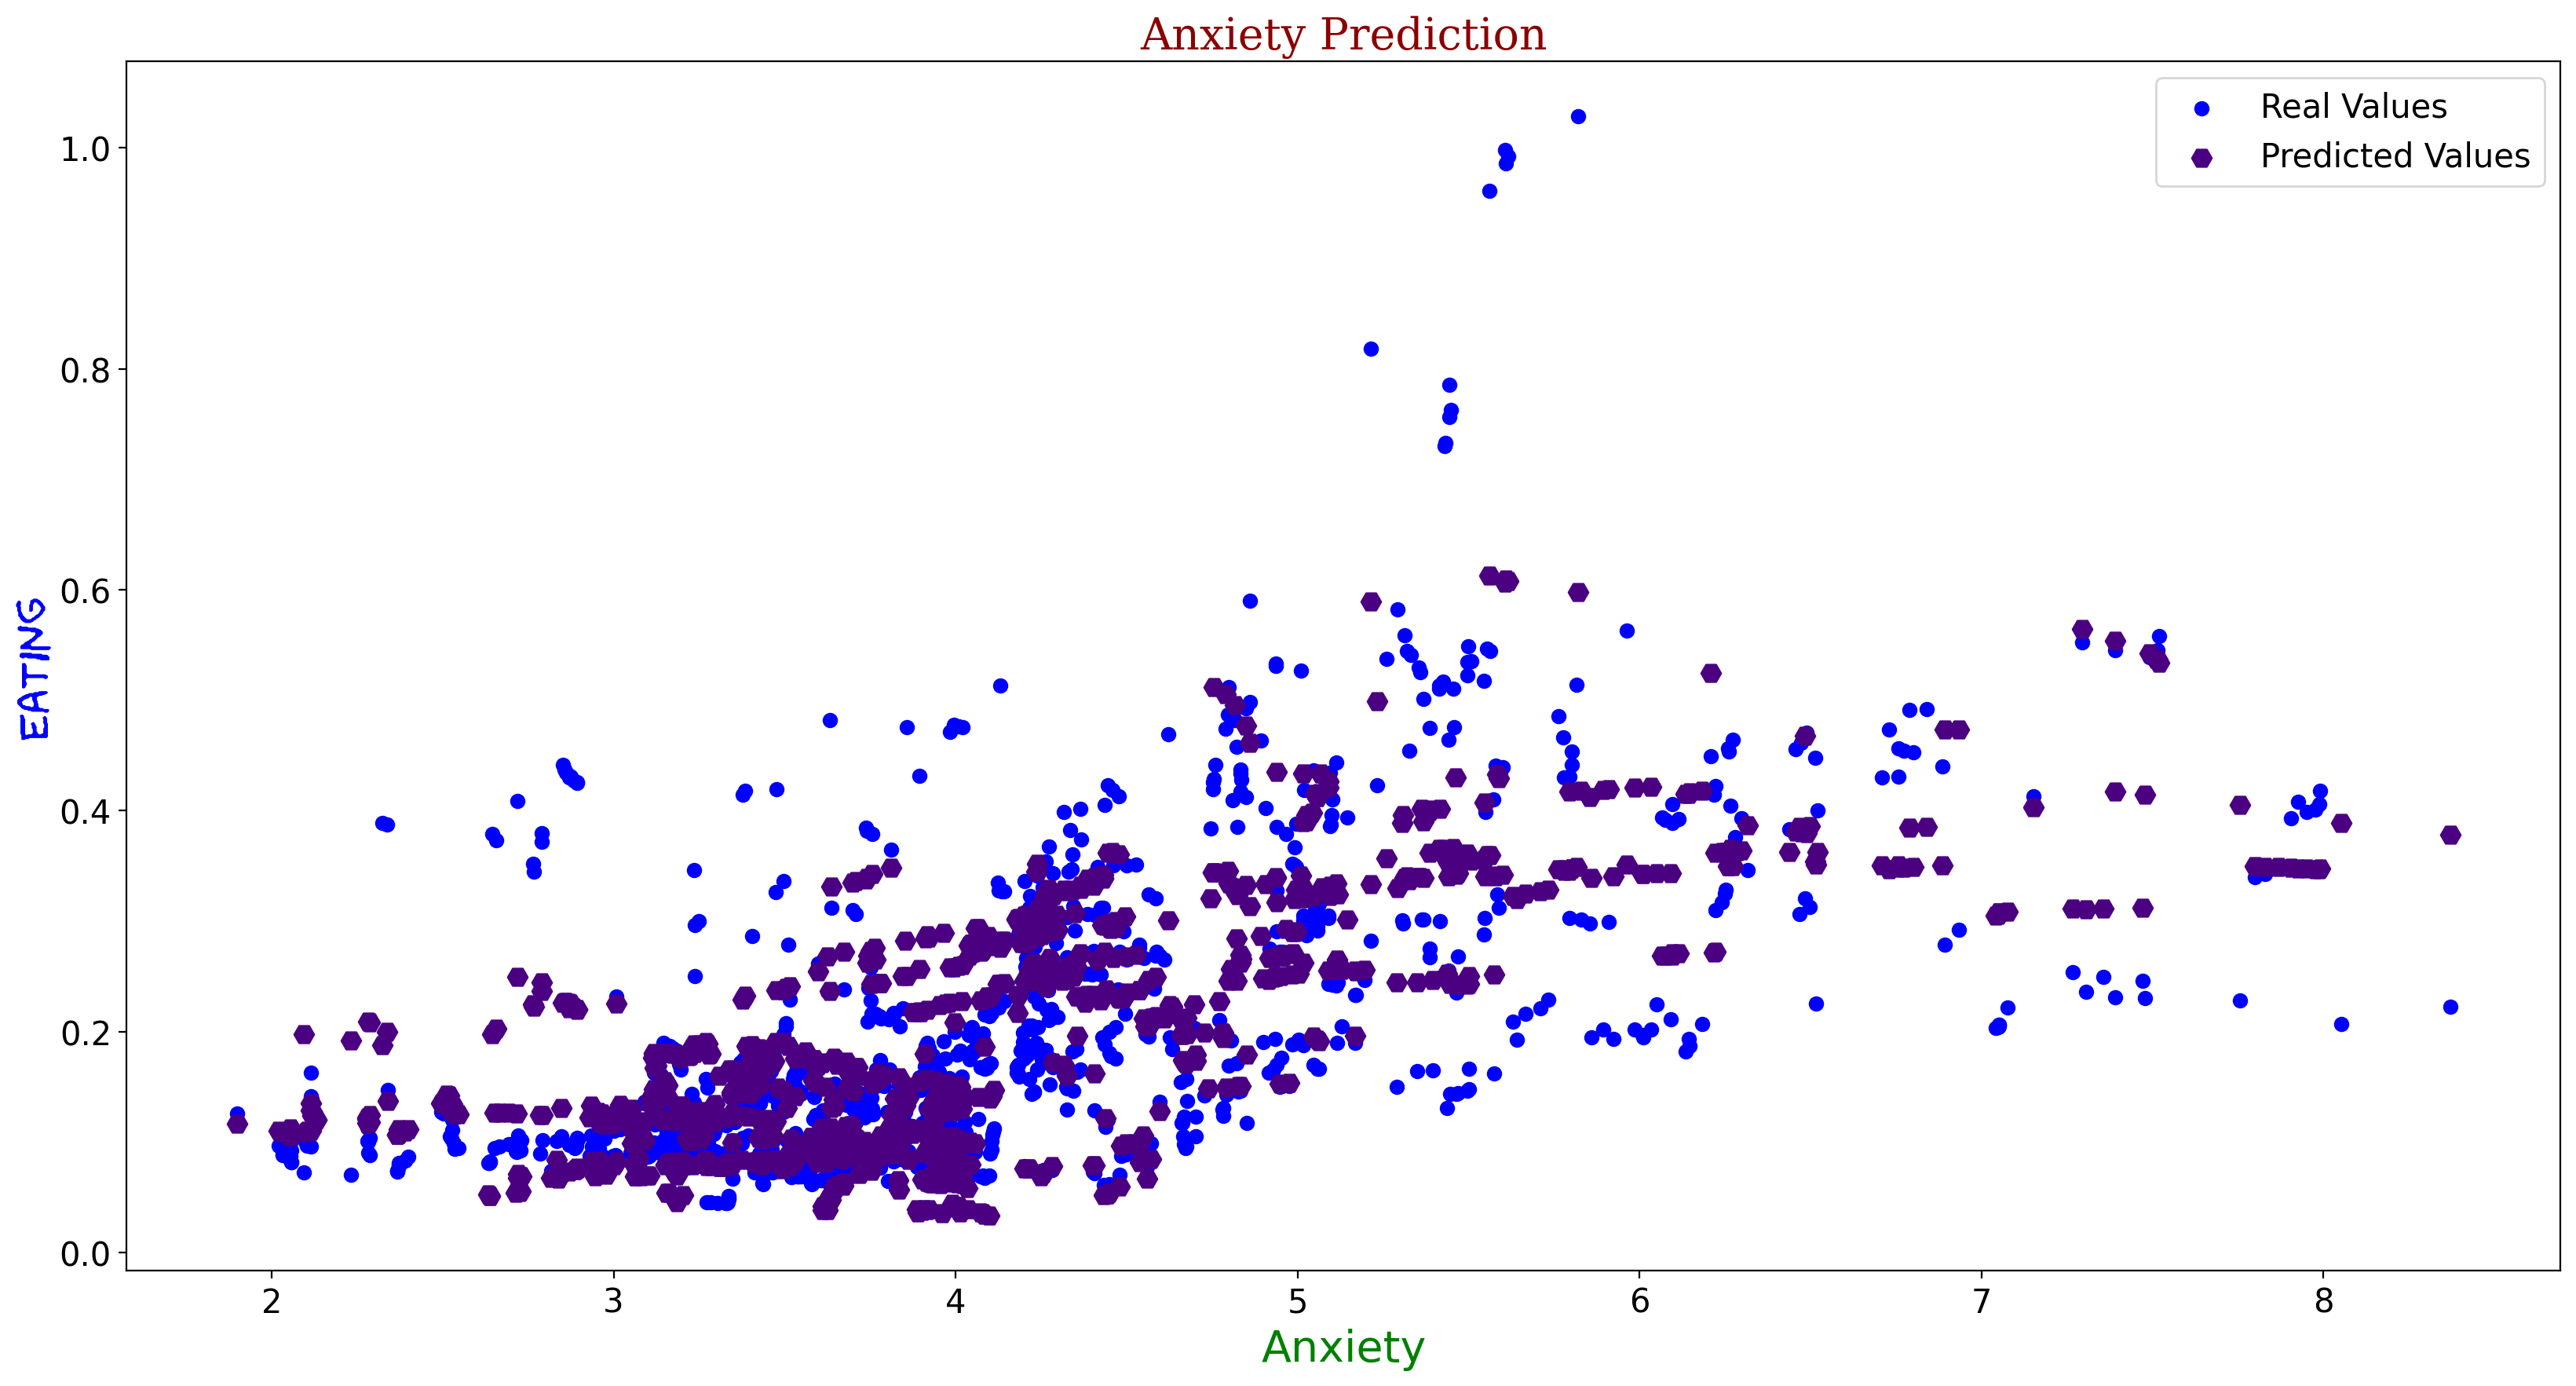

In [81]:
plt.figure(figsize= (20,10), dpi=200)
plt.title("Anxiety Prediction",fontdict=font2)
plt.xlabel("Anxiety",fontdict= font3)
plt.ylabel("Eating",fontdict=font1)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.scatter(a2,b2, color = 'blue', label = "Real Values")
plt.scatter(c2,d2, color = 'indigo', label = "Predicted Values", marker="H", s=80)
plt.legend(fontsize=15)
plt.show()

In [82]:
a3 = X_test["Depressive disorders"]
b3 = y_test
c3 = X_test["Depressive disorders"]
d3 = y_pred

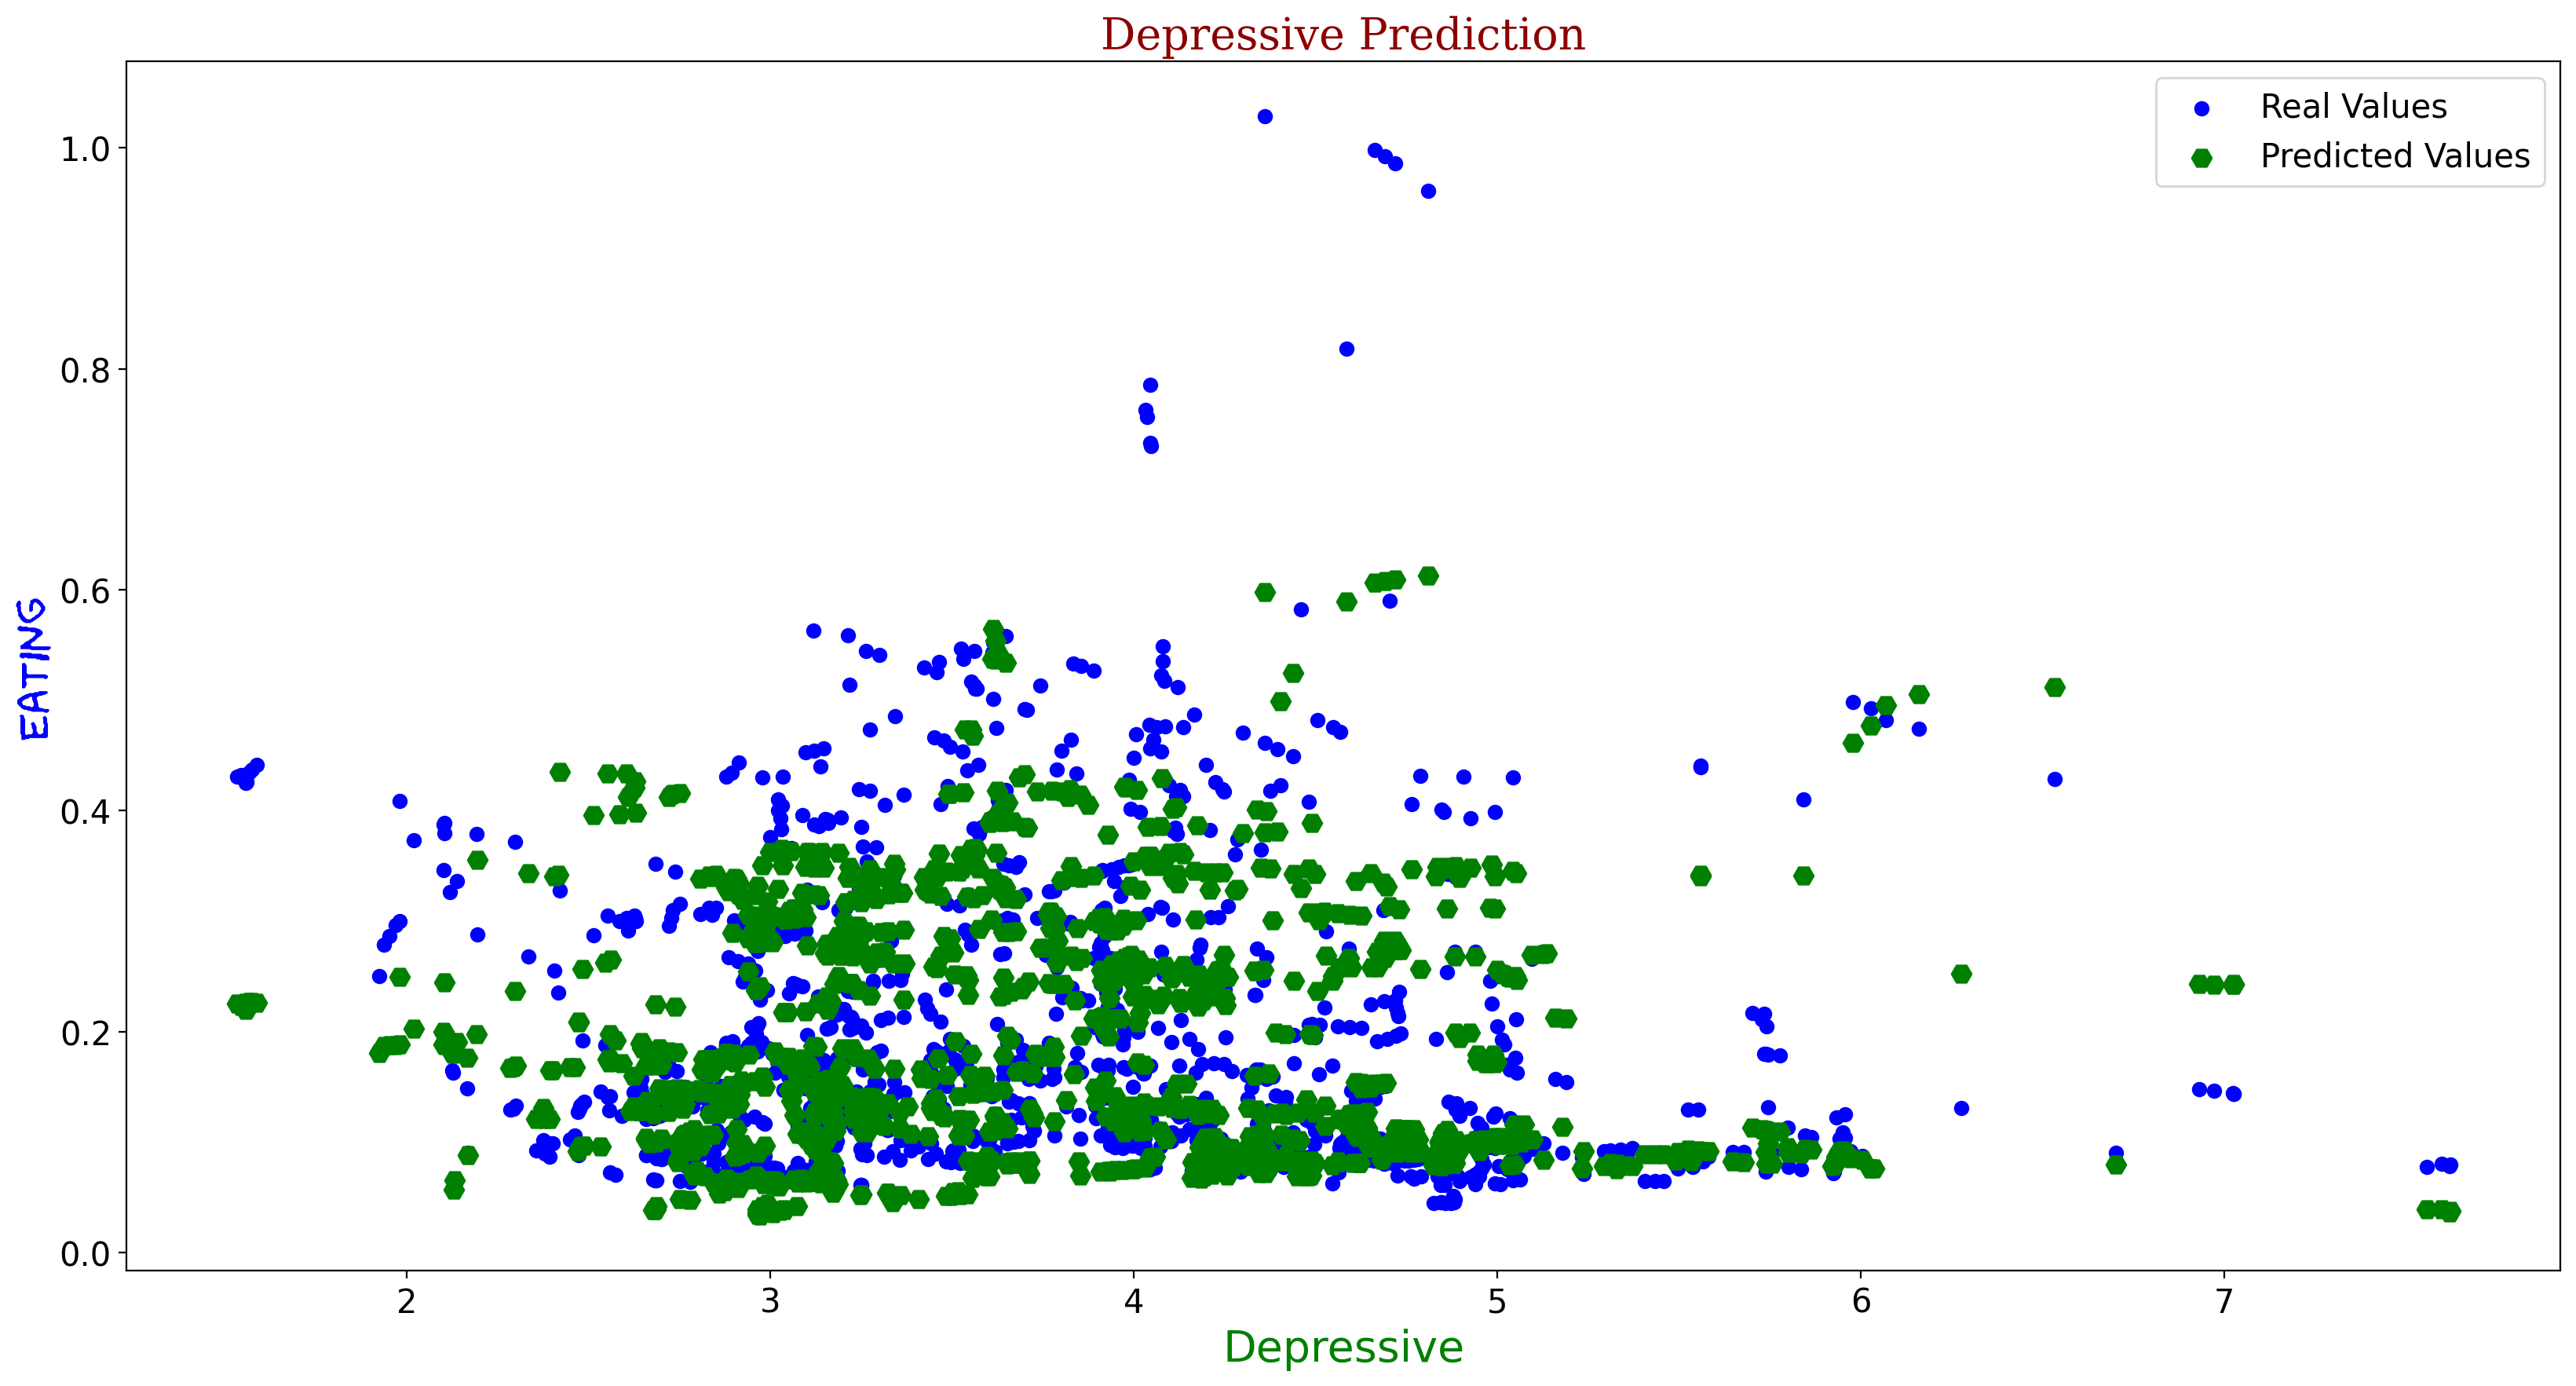

In [83]:
plt.figure(figsize= (20,10), dpi=200)
plt.title("Depressive Prediction",fontdict=font2)
plt.xlabel("Depressive",fontdict= font3)
plt.ylabel("Eating",fontdict=font1)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.scatter(a3,b3, color = 'blue', label = "Real Values")
plt.scatter(c3,d3, color = 'green', label = "Predicted Values", marker="H", s=80)
plt.legend(fontsize=15)
plt.show()